In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

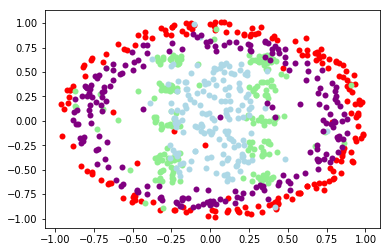

In [2]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

<h1>VOTING</h1>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 0.1, random_state = 0, solver = "newton-cg", multi_class="multinomial")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel = "rbf", random_state = 0, gamma = 1, C = 100.0, probability = True)]])

#training
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN','Nonliear_SVC']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3,pipe4], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))
    
print('\n[Voting]')
best_vt, best_w, best_score = None, (), -1
weight = [0,1,2,3]
for a, b, c, d in list(itertools.permutations(weight)): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3), ('svc', pipe4)], 
                           voting='soft', weights=[a,b,c,d])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c,d), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

#testing
clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3), ('svc', pipe4)], 
                        voting='soft', weights=[0,1,2,3])

vote_clf = clf.fit(X_train, y_train)
y_test_pred = vote_clf.predict(X_test)
vote_test = accuracy_score(y_test, y_test_pred) 
print('[Voting] auc-test = %.3f' %  vote_test)

[Individual]
LogisticRegression: 0.331 (+/- 0.058)
DecisionTree: 0.766 (+/- 0.045)
KNN: 0.810 (+/- 0.052)
Nonliear_SVC: 0.866 (+/- 0.025)

[Voting]
(0, 1, 2, 3): 0.863 (+/- 0.025)
(0, 1, 3, 2): 0.856 (+/- 0.030)
(0, 2, 1, 3): 0.818 (+/- 0.039)
(0, 2, 3, 1): 0.817 (+/- 0.046)
(0, 3, 1, 2): 0.766 (+/- 0.045)
(0, 3, 2, 1): 0.766 (+/- 0.045)
(1, 0, 2, 3): 0.859 (+/- 0.043)
(1, 0, 3, 2): 0.842 (+/- 0.050)
(1, 2, 0, 3): 0.791 (+/- 0.043)
(1, 2, 3, 0): 0.788 (+/- 0.041)
(1, 3, 0, 2): 0.766 (+/- 0.045)
(1, 3, 2, 0): 0.766 (+/- 0.045)
(2, 0, 1, 3): 0.857 (+/- 0.042)
(2, 0, 3, 1): 0.823 (+/- 0.053)
(2, 1, 0, 3): 0.854 (+/- 0.029)
(2, 1, 3, 0): 0.820 (+/- 0.045)
(2, 3, 0, 1): 0.766 (+/- 0.045)
(2, 3, 1, 0): 0.766 (+/- 0.045)
(3, 0, 1, 2): 0.845 (+/- 0.046)
(3, 0, 2, 1): 0.835 (+/- 0.049)
(3, 1, 0, 2): 0.819 (+/- 0.025)
(3, 1, 2, 0): 0.808 (+/- 0.043)
(3, 2, 0, 1): 0.766 (+/- 0.045)
(3, 2, 1, 0): 0.766 (+/- 0.045)

Best (0, 1, 2, 3): 0.863
[Voting] auc-test = 0.858


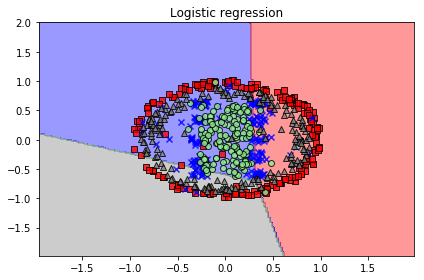

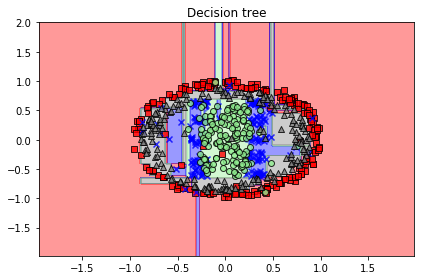

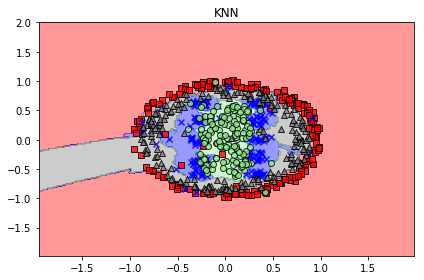

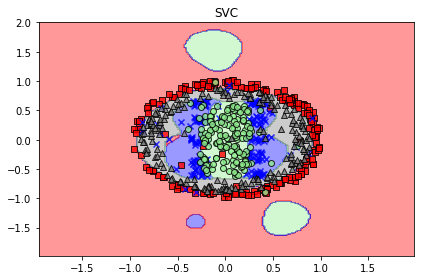

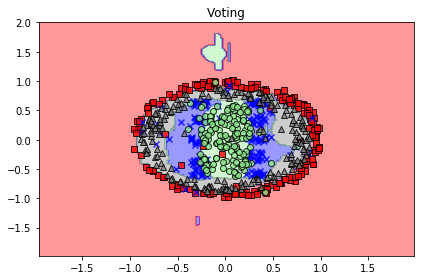

In [4]:
clf_labels =['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Voting']
colors = ['black', 'orange', 'blue','red' ,'green']
linestyles = ['-', '-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, pipe4, best_vt], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
###############################################
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe1,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe4,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('SVC')
plt.tight_layout()
plt.savefig('./output/fig-voting-svc-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

<h1>BAGGING</h1>

In [5]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
svc = SVC(kernel = "rbf", random_state = 0, gamma = 1, C = 100.0, probability = True)

bag_TREE = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

bag_SVC = BaggingClassifier(base_estimator=svc, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# single Nonlinear SVC
svc = svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
svc_train = accuracy_score(y_train, y_train_pred)
svc_test = accuracy_score(y_test, y_test_pred)
print('[Nonlinear_SVC] accuracy-train = %.3f, accuracy-test = %.3f' % (svc_train, svc_test))

# Bagging
bag_TREE = bag_TREE.fit(X_train, y_train)
y_train_pred = bag_TREE.predict(X_train)
y_test_pred = bag_TREE.predict(X_test)

bag_TREE_train = accuracy_score(y_train, y_train_pred) 
bag_TREE_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging TREE] auc-train = %.3f, auc-test = %.3f' % (bag_TREE_train, bag_TREE_test))

bag_SVC = bag_SVC.fit(X_train, y_train)
y_train_pred = bag_SVC.predict(X_train)
y_test_pred = bag_SVC.predict(X_test)

bag_SVC_train = accuracy_score(y_train, y_train_pred) 
bag_SVC_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging SVC] auc-train = %.3f, auc-test = %.3f' % (bag_SVC_train, bag_SVC_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.750
[Nonlinear_SVC] accuracy-train = 0.873, accuracy-test = 0.865
[Bagging TREE] auc-train = 0.997, auc-test = 0.824
[Bagging SVC] auc-train = 0.883, auc-test = 0.872


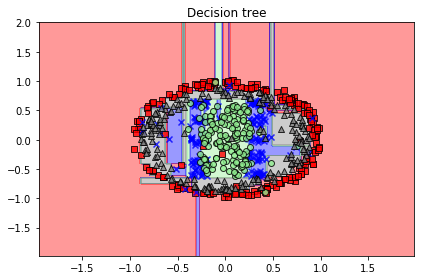

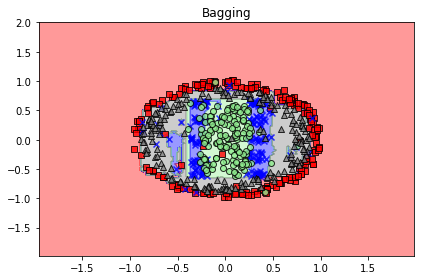

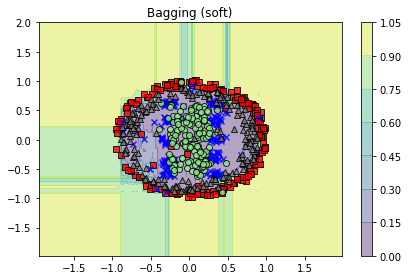

In [6]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-bagging-decision-tree-boundary.png', dpi=300)
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag_TREE, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag_TREE, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging (soft)')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary-soft.png', dpi=300)
plt.show()

<h1>BOOSTING</h1>

In [7]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.381, accuracy-test = 0.324
[AdaBoost] accuracy-train = 0.517, accuracy-test = 0.500


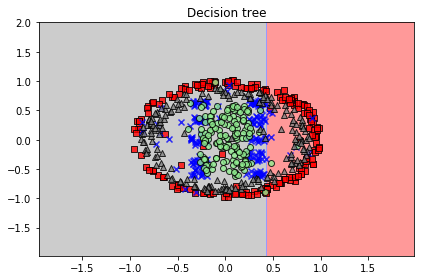

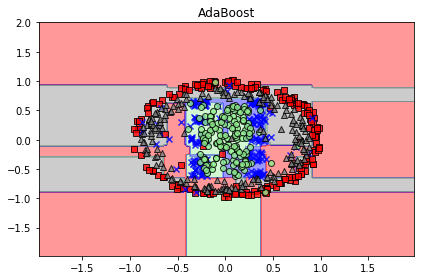

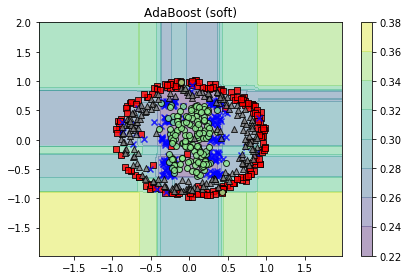

In [8]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary-soft.png', dpi=300)
plt.show()

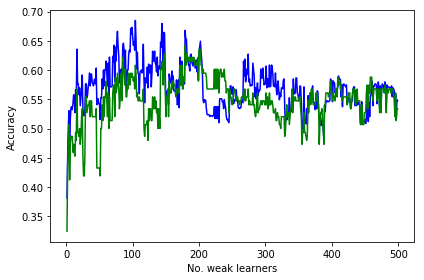

Best L = 179


In [9]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

Best_L = ada_test.index(max(ada_test))+1
print("Best L = %d" % Best_L)

In [10]:
ada179 = AdaBoostClassifier(base_estimator=tree, n_estimators=179,learning_rate=1, random_state=1)
ada179 = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada179_train = accuracy_score(y_train, y_train_pred) 
ada179_test = accuracy_score(y_test, y_test_pred) 
print('[ada179] auc-train = %.3f, auc-test = %.3f' % (ada179_train, ada179_test))

[ada179] auc-train = 0.547, auc-test = 0.534


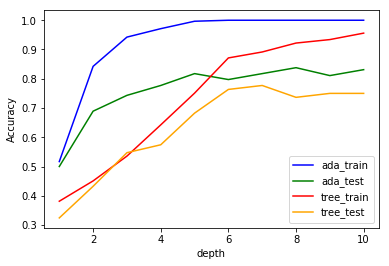

Best depth = 8
[DecisionTree] accuracy-train = 0.922, accuracy-test = 0.736
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.838


In [11]:
tree_train_score, tree_test_score = [], []
ada_train_score, ada_test_score = [], []
range_est = range(1, 11)

for i in range_est:
    #print('\n depth = %d' % i)
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    # single decision tree
    tree = tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    tree_train = accuracy_score(y_train, y_train_pred)
    tree_train_score.append(tree_train)
    tree_test = accuracy_score(y_test, y_test_pred)
    tree_test_score.append(tree_test)
    #print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

    # adaboost
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train = accuracy_score(y_train, y_train_pred)
    ada_train_score.append(ada_train)
    ada_test = accuracy_score(y_test, y_test_pred)
    ada_test_score.append(ada_test)
    #print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (ada_train, ada_test))
    
plt.plot(range_est, ada_train_score, color='blue', label = 'ada_train')
plt.plot(range_est, ada_test_score, color='green', label = 'ada_test')
plt.plot(range_est, tree_train_score, color='red', label = 'tree_train')
plt.plot(range_est, tree_test_score, color='orange', label = 'tree_test')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.show()

best_depth = ada_test_score.index(max(ada_test_score))+1
print("Best depth = %d" % best_depth)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train_score[best_depth-1], tree_test_score[best_depth-1]))
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train_score[best_depth-1], ada_test_score[best_depth-1]))

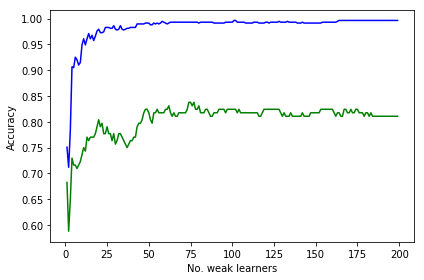

Best L = 74


In [12]:
range_est = range(1, 200)
ada_train, ada_test = [], []
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

Best_L = ada_test.index(max(ada_test))+1
print("Best L = %d" % Best_L)

In [13]:

ada74 = AdaBoostClassifier(base_estimator=tree, n_estimators=74,learning_rate=1, random_state=1)
ada74 = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada74_train = accuracy_score(y_train, y_train_pred) 
ada74_test = accuracy_score(y_test, y_test_pred) 
print('[ada74] auc-train = %.3f, auc-test = %.3f' % (ada74_train, ada74_test))

[ada74] auc-train = 0.997, auc-test = 0.811


<h2>Conclusion</h2>

<h4>voting model:</h4>

|model|LogisticRegression|DecisionTree|KNN|SVC|
|-----|------------------|------------|---|---|
|weight|0|1|2|3|

<center>accuary on test data: 0.858</center>


<h4>bagging model:</h4>

|model|base_estimator|bagged estimator|
|-----|--------------|----------------|
|DecisionTree|0.750|0.824|
|Nonlinear SVC|0.865|0.872|

<center>accuary on test data</center>

<h4>boosting models:</h4>

|tree depth|base_estimator|adaboost|L|
|--------------|-------|---|---|
|1|0.324|0.500|500|
|1|0.547|0.534|179|
|8|0.730|0.838|500|
|8|0.730|0.811|74|

<center>accuary on test data</center>